In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## Baseline model with both info from the source and target country as features

In [119]:
feature_data = pd.read_csv('../data/features/features_interpolated.csv', encoding='latin-1', engine='python')
feature_data.drop(columns=['Unnamed: 0'], inplace=True)
migration_data = pd.read_csv('../data/labels/OECD_acquisition_data_interpolated.csv', encoding='latin-1', engine='python')
migration_data.drop(columns=['Unnamed: 0'], inplace=True)

print(feature_data.columns)
print(migration_data.columns)

Index(['Country', 'Year', 'Carbon Emissions', 'Education Expenditure',
       'Foreign Direct Investment (FDI) Inflows', 'GDP', 'Health Expenditure',
       'Inflation Rate', 'Internet Penetration', 'Life Expectancy',
       'Renewable Energy Production', 'Unemployment Rate'],
      dtype='object')
Index(['CO2', 'COU', 'Year', 'Value'], dtype='object')


In [120]:
# Merge the first two datasets based on country and year
merged_data = pd.merge(feature_data, migration_data, left_on=["Country", "Year"], right_on=["COU", "Year"])

# Merge the third dataset based on country and year
merged_data = pd.merge(feature_data, merged_data, left_on=["Country", "Year"], right_on=["CO2", "Year"])

merged_data.drop(columns=["Year","Country_x","Country_y","COU", "CO2"], inplace=True)

label_column = "Value"

# Normalize the data between 0 and 1
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(merged_data.drop(columns=[label_column]))
normalized_labels = scaler.fit_transform(merged_data[label_column].values.reshape(-1, 1))

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(normalized_features, normalized_labels, test_size=0.3, random_state=42)
print(merged_data.drop(columns=[label_column]).columns)

Index(['Carbon Emissions_x', 'Education Expenditure_x',
       'Foreign Direct Investment (FDI) Inflows_x', 'GDP_x',
       'Health Expenditure_x', 'Inflation Rate_x', 'Internet Penetration_x',
       'Life Expectancy_x', 'Renewable Energy Production_x',
       'Unemployment Rate_x', 'Carbon Emissions_y', 'Education Expenditure_y',
       'Foreign Direct Investment (FDI) Inflows_y', 'GDP_y',
       'Health Expenditure_y', 'Inflation Rate_y', 'Internet Penetration_y',
       'Life Expectancy_y', 'Renewable Energy Production_y',
       'Unemployment Rate_y'],
      dtype='object')


# XGBoost

In [121]:
!pip install xgboost

In [122]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define the XGBoost model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.00013010594431415773


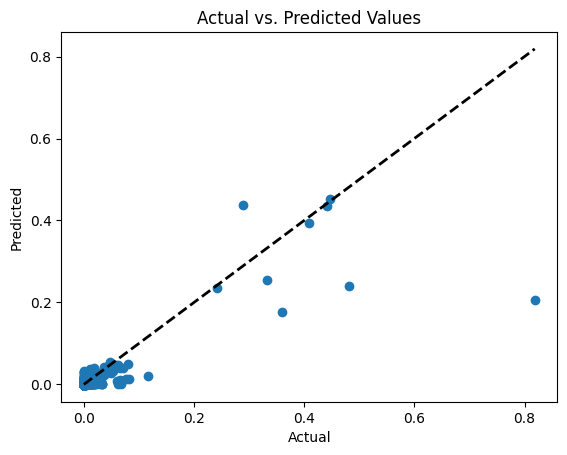

Mean Squared Error: 0.00013010594431415773


In [123]:
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred = model.predict(X_test)

# Plot the actual vs. predicted values for the test data
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Randomforest

C:\Users\marti\AppData\Local\Temp\ipykernel_17128\629600719.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train_log)


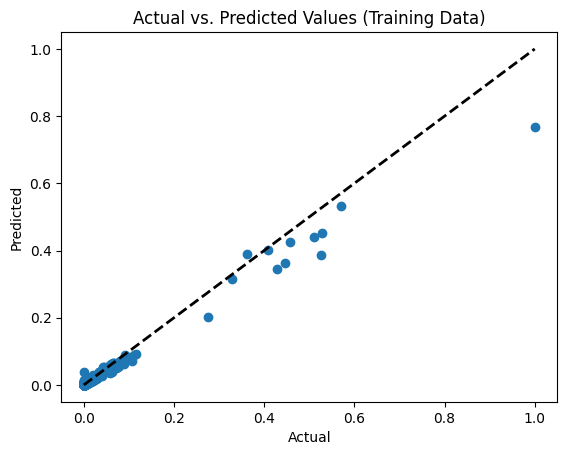

Mean Squared Error (Training Data): 1.1913301133014248e-05


In [124]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Logarithmic transformation of the target variable
y_train_log = np.log1p(y_train)

# Define the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train_log)

# Make predictions on the training data
y_train_pred_log = model.predict(X_train)

# Inverse transform the predictions
y_train_pred = np.expm1(y_train_pred_log)

# Plot the actual vs. predicted values for the training data
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Training Data)')
plt.show()

# Calculate the mean squared error on the training data
mse_train = mean_squared_error(y_train, y_train_pred)
print("Mean Squared Error (Training Data):", mse_train)


# Convert to buckets

In [125]:
# Perform binning to split the values into classes based on the distribution
class_labels = pd.qcut(merged_data[label_column], q=3, labels=False)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(normalized_features, class_labels, test_size=0.3, random_state=42)

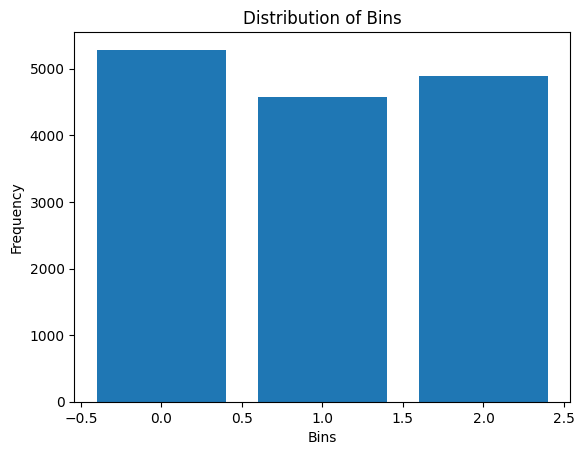

In [126]:
# Compute the bin frequencies
bin_counts = np.bincount(class_labels)

# Plot the bar plot of the bin frequencies
plt.bar(range(len(bin_counts)), bin_counts)
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Distribution of Bins')
plt.show()

# XGBoost Classifier

In [127]:
import xgboost as xgb
from sklearn.metrics import classification_report

# Train the XGBoost classifier
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
classification_metrics = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_metrics)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1608
           1       0.74      0.74      0.74      1332
           2       0.91      0.90      0.90      1483

    accuracy                           0.84      4423
   macro avg       0.84      0.84      0.84      4423
weighted avg       0.84      0.84      0.84      4423



In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Train the Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
classification_metrics = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_metrics)

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1608
           1       0.75      0.75      0.75      1332
           2       0.91      0.89      0.90      1483

    accuracy                           0.84      4423
   macro avg       0.84      0.84      0.84      4423
weighted avg       0.84      0.84      0.84      4423

